### Medical Image Segmentation and Applicationo Project(MISA) 

In [11]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jan 16 21:39:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [13]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


**Import libraries**

In [14]:
import os
import numpy as np
import random
from scipy.ndimage import gaussian_filter
np.random.seed(777)
import cv2
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras import Model
import keras
from keras import layers
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt # plotting purposes

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [15]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


**Define parameters**

In [19]:
##   Cell_1
# dataset parameters
FNAME_PATTERN = '/content/drive/MyDrive/MiSa/Resampled/IBSR_{}_{}.nii.gz'

# training parameters
N_EPOCHS = 50
BATCH_SIZE = 16
PATIENCE = 15
MODEL_FNAME_PATTERN = 'Best_model.h5'
OPTIMISER = 'Adam'
LOSS = 'categorical_crossentropy'
N_VOLUMES = 15
IMAGE_SIZE = (256,192,256)

# network parameters
N_CLASSES = 4
N_INPUT_CHANNELS = 1
PATCH_SIZE = (64, 64)
PATCH_STRIDE = (32, 32)

# training, validation, test parameters
TRAINING_VOLUMES = [0, 1, 2, 3, 4, 5, 6,7,8,9]
VALIDATION_VOLUMES = [10,11, 12,13,14]

# data preparation parameters range from[0.2 to 0.6]
CONTENT_THRESHOLD = 0.4


In [ ]:
import SimpleITK as sitk

In [18]:
 ### Cell_2

##### Bias field correction cell
def N4():
    print("N4 bias correction runs.")
    inputImage = sitk.ReadImage("/content/drive/MyDrive/MiSa/Data_set/train/IBSR_04.nii.gz")
    maskImage = sitk.OtsuThreshold(inputImage,0,1,200)
    sitk.WriteImage(maskImage, "06-t1c_mask3.nii.gz")

    inputImage = sitk.Cast(inputImage,sitk.sitkFloat32)

    corrector = sitk.N4BiasFieldCorrectionImageFilter();

    output = corrector.Execute(inputImage,maskImage)
    sitk.WriteImage(output,"06-t1c_output3.nii.gz")
    print("Finished N4 Bias Field Correction.....")

In [ ]:
if __name__=='__main__':  #### being run standalone by the user
   N4()  #### Calling function 

In [ ]:
import os
import numpy as np
from nibabel.testing import data_path

In [ ]:
###### For saving the bias field corrected IBSR Datasets
filename1 = os.path.join(data_path, '/content/drive/MyDrive/MiSa/Data_set/train/IBSR_04.nii.gz')
filename2 = os.path.join(data_path, '/content/06-t1c_output.nii.gz')

**Define U-net architecture**

In [ ]:
def get_unet(img_size=PATCH_SIZE, n_classes=N_CLASSES, n_input_channels=N_INPUT_CHANNELS, scale=1):
    inputs = keras.Input(shape=img_size + (n_input_channels, ))

    # Encoding path
    conv1 = layers.Conv2D(32*scale, (3, 3), padding="same", activation='relu')(inputs)
    max1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(64*scale, (3, 3), padding="same", activation='relu')(max1)
    max2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = layers.Conv2D(128*scale, (3, 3), padding="same", activation='relu')(max2)
    max3 = layers.MaxPooling2D((2, 2))(conv3)
    #### ADDED
    conv4 = layers.Conv2D(256*scale, (3, 3), padding="same", activation='relu')(max3)
    max4 = layers.MaxPooling2D((2, 2))(conv4)

    lat = layers.Conv2D(256*scale, (3, 3), padding="same", activation='relu')(max4)

    # Decoding path
    up1 = layers.UpSampling2D((2, 2))(lat)
    concat1 = layers.concatenate([conv4, up1], axis=-1)
    conv5 = layers.Conv2D(128*scale, (3, 3), padding="same", activation='relu')(concat1)
    
    up2 = layers.UpSampling2D((2, 2))(conv5)
    concat2 = layers.concatenate([conv3, up2], axis=-1)
    conv6 = layers.Conv2D(64*scale, (3, 3), padding="same", activation='relu')(concat2)
    
    up3 = layers.UpSampling2D((2, 2))(conv6)
    concat3 = layers.concatenate([conv2, up3], axis=-1)
    conv6 = layers.Conv2D(64*scale, (3, 3), padding="same", activation='relu')(concat3)
       ### ADDED one layer
    up4 = layers.UpSampling2D((2, 2))(conv6)
    concat4 = layers.concatenate([conv1, up4], axis=-1)

    conv7 = layers.Conv2D(32*scale, (3, 3), padding="same", activation='relu')(concat4)

    outputs = layers.Conv2D(n_classes, (1, 1), activation="softmax")(conv7)

    model = keras.Model(inputs, outputs)

    return model

**Define SegNet architecture**

In [20]:
def get_segnet(img_size=PATCH_SIZE, n_classes=N_CLASSES, n_input_channels=N_INPUT_CHANNELS, scale=1):
    inputs = keras.Input(shape=img_size + (n_input_channels, ))

    # Encoding path
    conv1 = layers.Conv2D(32*scale, (3, 3), padding="same", activation='relu')(inputs)
    max1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(64*scale, (3, 3), padding="same", activation='relu')(max1)
    max2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = layers.Conv2D(128*scale, (3, 3), padding="same", activation='relu')(max2)
    max3 = layers.MaxPooling2D((2, 2))(conv3)

    lat = layers.Conv2D(256*scale, (3, 3), padding="same", activation='relu')(max3)

    # Decoding path
    up1 = layers.UpSampling2D((2, 2))(lat)
    conv4 = layers.Conv2D(128*scale, (3, 3), padding="same", activation='relu')(up1)
    
    up2 = layers.UpSampling2D((2, 2))(conv4)
    conv5 = layers.Conv2D(64*scale, (3, 3), padding="same", activation='relu')(up2)
    
    up3 = layers.UpSampling2D((2, 2))(conv5)
    conv6 = layers.Conv2D(32*scale, (3, 3), padding="same", activation='relu')(up3)

    outputs = layers.Conv2D(n_classes, (1, 1), activation="softmax")(conv6)

    model = keras.Model(inputs, outputs)

    return model

**Load the 15 volumes**

In [21]:
def load_data(n_volumes=N_VOLUMES, image_size=IMAGE_SIZE, fname_pattern=FNAME_PATTERN) :
  T1_volumes = np.zeros((n_volumes, *image_size, N_INPUT_CHANNELS))
  T2_volumes = np.zeros((n_volumes, *image_size, N_INPUT_CHANNELS))
  labels = np.zeros((n_volumes, *image_size, N_INPUT_CHANNELS))
  for i in range(n_volumes) :
    img_data = nib.load(fname_pattern.format(i+1, 'T1'))
    image = img_data.get_fdata()
    print(image.shape)
    volume = np.zeros((*image_size, N_INPUT_CHANNELS))
    print(volume.shape)
    start_a = (256 - image.shape[0])//2
    start_b = (256 - image.shape[2]) // 2
    print(start_a, start_b)
    volume[start_a:start_a + image.shape[0], :, start_b:start_b + image.shape[2], 0] = image
    T1_volumes[i] = volume# img_data.get_fdata()

    seg_data = nib.load(fname_pattern.format(i+1, 'seg'))
    image = seg_data.get_fdata()
    print(image.shape)
    volume = np.zeros((*image_size, N_INPUT_CHANNELS))
    print(volume.shape)
    start_a = (256 - image.shape[0])//2
    start_b = (256 - image.shape[2]) // 2
    print(start_a, start_b)
    volume[start_a:start_a + image.shape[0], :, start_b:start_b + image.shape[2], 0] = image


    labels[i] = volume          #seg_data.get_fdata()

  return (T1_volumes,_, labels)

In [ ]:
(T1_volumes,_, labels) = load_data()

-129.7516326904297 1406.8665771484375


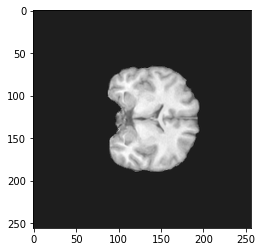

In [ ]:
print(T1_volumes.min(), T1_volumes.max())
plt.imshow(T1_volumes[3, :, 100, :, 0], cmap = "gray")

**loading or Spliting the volumes  into training and validation part**

In [23]:
training_volumes_T1 = T1_volumes[TRAINING_VOLUMES]
training_labels = labels[TRAINING_VOLUMES]

validation_volumes_T1 = T1_volumes[VALIDATION_VOLUMES]
validation_labels = labels[VALIDATION_VOLUMES]

(15, 256, 192, 256, 1)


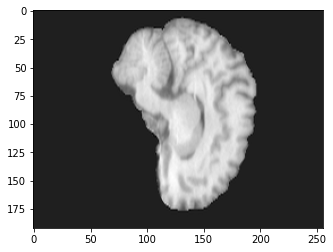

In [25]:
### checking correctness of Dataloading 
print(T1_volumes.shape)
plt.imshow(T1_volumes[3,138,:,:,0], cmap='gray')

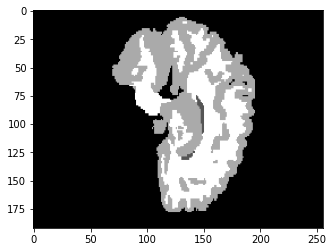

In [29]:
plt.imshow(labels[3,138,:,:,0], cmap ='gray')

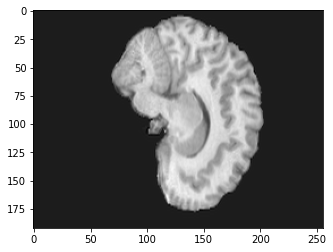

In [30]:
plt.imshow(validation_volumes_T1[3,138,:,:,0], cmap ='gray')

**Pre-process data**

In [ ]:
## Cell_3


### Standardization part of the cell 
def z_score_standardisation(x, avg, std):
  return (x-avg)/std

ref_avg = training_volumes_T1[training_labels!=0].mean()
ref_std = training_volumes_T1[training_labels!=0].std()

training_volumes_T1 = z_score_standardisation(training_volumes_T1, ref_avg, ref_std)
validation_volumes_T1 = z_score_standardisation(validation_volumes_T1, ref_avg, ref_std)

**Synthetic data** or **Image generator**

In [ ]:
 ## Cell_4

import random
from scipy.ndimage import gaussian_filter

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, labels, shuffle=True):
        'Initialization'
        self.dim = PATCH_SIZE
        self.batch_size = BATCH_SIZE
        self.list_IDs = range(labels.shape[0])
        self.labels = labels
        self.n_channels = N_INPUT_CHANNELS
        self.n_classes = N_CLASSES
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=float)
        Y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            map = self.labels[ID]

            sample = np.zeros_like(map)

            sample[map == 1] = np.random.normal(175.97978412, 62.56217898)
            sample[map == 2] = np.random.normal(231.44596825, 20.93681171)
            sample[map == 3] = np.random.normal(257.48750258, 24.89890488)

            sample = gaussian_filter(sample, sigma=np.abs(np.random.normal(1, 0.25)))

            noise = np.random.normal(0, 20, size=map.shape)

            sample = sample + noise

            sample[map == 0] = 0

            X[i, ] = (sample - 289.43550817663186) / 125.09902733275413

            # Store class
            Y[i, ] =  tf.keras.utils.to_categorical(map, num_classes=self.n_classes)

        return X, Y

In [ ]:
training_generator = DataGenerator(training_patches_seg) ## calling function 

In [ ]:
for x in training_generator : # Checking generated Imags 
  break

plt.imshow(x[0][1, :, :, 0],cmap ='gray')

**Extract *useful* patches**

This step is fundamental, we want to provide the network with useful information

In [31]:
 ## Cell_5
def extract_patches(x, patch_size, patch_stride) :
  return tf.image.extract_patches(
    x,
    sizes=[1, *patch_size, 1],
    strides=[1, *patch_stride, 1],
    rates=[1, 1, 1, 1],
    padding='SAME', name=None)

In [32]:
 ### Cell_5
def extract_useful_patches(
    volumes, labels,
    image_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    stride=PATCH_STRIDE,
    threshold=CONTENT_THRESHOLD,
    num_classes=N_CLASSES) :
  volumes = volumes.reshape([-1, image_size[1], image_size[2], 1])
  labels = labels.reshape([-1, image_size[1], image_size[2], 1])

  vol_patches = extract_patches(volumes, patch_size, stride).numpy()
  seg_patches = extract_patches(labels, patch_size, stride).numpy()

  vol_patches = vol_patches.reshape([-1, *patch_size, 1])
  seg_patches = seg_patches.reshape([-1, *patch_size, ])

  foreground_mask = seg_patches != 0

  useful_patches = foreground_mask.sum(axis=(1, 2)) > threshold * np.prod(patch_size)

  vol_patches = vol_patches[useful_patches]
  seg_patches = seg_patches[useful_patches]

  seg_patches = tf.keras.utils.to_categorical(
    seg_patches, num_classes=N_CLASSES, dtype='float32')
  
  return (vol_patches, seg_patches)

In [33]:
# extract patches from training set
(training_patches_T1, training_patches_seg) = extract_useful_patches(training_volumes_T1, training_labels)
# extract patches from validation set
(validation_patches_T1, validation_patches_seg) = extract_useful_patches(validation_volumes_T1, validation_labels)

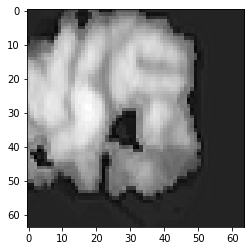

In [34]:
plt.imshow(training_patches_T1[0,:,:,0], cmap ='gray')

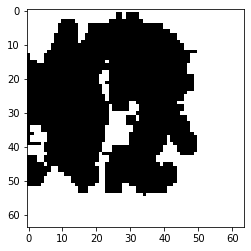

In [35]:
plt.imshow(training_patches_seg[0,:,:,0],cmap ='gray')

(6054, 64, 64, 1)


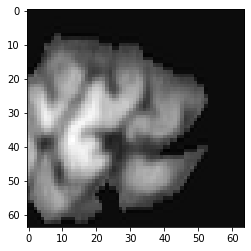

In [ ]:
print(validation_patches_T1.shape)
plt.imshow(validation_patches_T1[0,:,:,0],cmap ='gray')

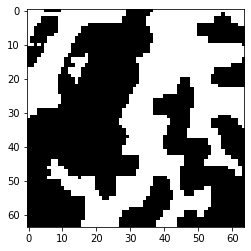

In [36]:
plt.imshow(validation_patches_seg[200,:,:,3],cmap ='gray')

**SegNet or U-net model and train it**



In [38]:
 #### Cell_6
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=PATIENCE),
    tf.keras.callbacks.ModelCheckpoint(filepath=MODEL_FNAME_PATTERN, save_best_only=True)
]

# Generators
#training_generator = DataGenerator(training_patches_seg) ### If needed 

segnet = get_segnet()
segnet.compile(optimizer=OPTIMISER, loss=LOSS)
histroy=segnet.fit(
    x=training_patches_T1, ## x= training_generator # To see the effect of synthetic images
    y=training_patches_seg,
    validation_data=(validation_patches_T1, validation_patches_seg),
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS,
    callbacks=my_callbacks,
    verbose=1)

Epoch 1/50
893/893 [==============================] - 20s 12ms/step - loss: 0.3887 - val_loss: 0.4175
Epoch 2/50
893/893 [==============================] - 10s 11ms/step - loss: 0.2454 - val_loss: 0.3679
Epoch 3/50
893/893 [==============================] - 10s 11ms/step - loss: 0.2101 - val_loss: 0.3453
Epoch 4/50
893/893 [==============================] - 10s 11ms/step - loss: 0.1879 - val_loss: 0.3584
Epoch 5/50
893/893 [==============================] - 10s 11ms/step - loss: 0.1738 - val_loss: 0.3419
Epoch 6/50
893/893 [==============================] - 10s 11ms/step - loss: 0.1622 - val_loss: 0.3654
Epoch 7/50
893/893 [==============================] - 10s 11ms/step - loss: 0.1536 - val_loss: 0.3630
Epoch 8/50
893/893 [==============================] - 10s 11ms/step - loss: 0.1472 - val_loss: 0.3799
Epoch 9/50
893/893 [==============================] - 10s 11ms/step - loss: 0.1410 - val_loss: 0.3785
Epoch 10/50
893/893 [==============================] - 10s 11ms/step - loss: 0.136

In [ ]:
N_EPOCHS =21 ### Updating the Epoch number 

We could stop training when validation loss increases substantially

In [ ]:
plt.figure()
plt.plot(range(N_EPOCHS), histroy.history['loss'], label='loss')
plt.plot(range(N_EPOCHS), histroy.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

Using callbacks to stop training and avoid overfitting


*   Early stopping with a certain patience
*   Save (and load!) best model



In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=PATIENCE),
    tf.keras.callbacks.ModelCheckpoint(filepath=MODEL_FNAME_PATTERN, save_best_only=True)
]

**Load best model**

In [ ]:
segnet = get_segnet(
    img_size=(IMAGE_SIZE[1], IMAGE_SIZE[2]),
    n_classes=N_CLASSES,
    n_input_channels=N_INPUT_CHANNELS)
segnet.compile(optimizer=OPTIMISER, loss=LOSS)
segnet.load_weights('Best_model.h5')

**Prepare test data**

In [ ]:
n_volume =1
image_size =IMAGE_SIZE
FNAME_PATTERN_1 = '/content/drive/MyDrive/MiSa/Test_Set/test_images/IBSR_02.nii.gz'
T1_test = np.zeros((n_volume, *image_size, N_INPUT_CHANNELS))
img_data = nib.load(FNAME_PATTERN_1)
T2_test = img_data.get_fdata()

In [ ]:
testing_volumes_T1 =T2_test

In [ ]:
testing_volumes_T1.shape

(1, 256, 128, 256, 1)

In [ ]:
testing_volumes_T1_processed = testing_volumes_T1.reshape([-1, IMAGE_SIZE[1], IMAGE_SIZE[2], 1])
testing_labels_processed = testing_labels.reshape([-1, IMAGE_SIZE[1], IMAGE_SIZE[2], 1])

testing_labels_processed = tf.keras.utils.to_categorical(
testing_labels_processed, num_classes=4, dtype='float32')

In [ ]:
testing_volumes_T1_processed.shape

(256, 128, 256, 1)

**Predict labels for test data**

In [ ]:
prediction = segnet.predict(x=testing_volumes_T1_processed)

prediction = np.argmax(prediction, axis=3)

plt.imshow(prediction[:, :, 155])

In [ ]:
plt.imshow(testing_labels_processed[:,:,155, 2])
print(testing_labels_processed.shape)
print(np.unique(testing_labels_processed))


**Compute DSC for test data**

In [ ]:
def compute_dice(prediction, labels) :
  prediction = prediction.squeeze()
  labels = labels.squeeze()
  for c in np.unique(prediction) :
    intersection = np.logical_and(prediction == c, labels==c).sum()
    union = (prediction == c).sum() + (labels==c).sum()
    print(f'Dice coefficient class {c} equal to {2 * intersection / union : .2f}')

compute_dice(prediction, testing_labels)

In [ ]:
!pip install seg-metrics

In [ ]:
!pip install SimpleITK

In [ ]:
!pip install medutils

In [ ]:
import seg_metrics.seg_metrics as sg ##importing segmentation metrics 

In [ ]:
testing_volumes_T1_processed.shape

In [ ]:
testing_labels.shape

In [ ]:
labels = [0, 1, 2,3]
pred_img = prediction
gdth_img = testing_labels[0,:,:,:,0]
csv_file = 'metrics.csv'

metrics = sg.write_metrics(labels=labels[0:],  #Including  background if needed
                  gdth_img=gdth_img,
                  pred_img=pred_img,
                  csv_file=csv_file,
                  metrics=['dice', 'hd','vs']) ## calculating the Hausdorff Difference and AVD

'''
metrics = sg.write_metrics(labels=labels[1:],  # exclude background if needed
                  gdth_img=gdth_img,
                  pred_img=pred_img,
                  csv_file=csv_file,
                  metrics=['dice', 'hd','vs'])
'''



In [ ]:
metrics ###  displaying result 

**Saving the prediction as Nifti Image format**

In [ ]:
import nibabel as nib
gtVolum_path = '/content/drive/MyDrive/MiSa/Validation_Set/Dataset/IBSR_13.nii.gz'
img = nib.load(gtVolum_path)
img.header.set_data_shape=prediction.shape#(256,128,256)
array_img = nib.Nifti1Image(prediction, img.affine,img.header)
nib.save(array_img, '/content/drive/MyDrive/MiSa/IBSR_14.nii.gz')

In [ ]:
img.get_affine
img.header

In [ ]:
array_img.update_header()
nib.save(array_img, '/content/drive/MyDrive/MiSa/IBSR_13.nii.gz') ## Saving the prediction as Nifti Image